In [1]:
import pandas as pd
from icevision.all import *

In [2]:
final_data1 = pd.read_csv('final_labels.csv')

In [3]:
final_data1.shape

(845029, 12)

In [4]:
template_record = ObjectDetectionRecord()

In [5]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


In [6]:
class DataParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)

        self.data_dir = data_dir
        self.df = pd.read_csv("final_labels.csv").iloc[:200000,:]
        self.class_map = ClassMap(list(self.df['category'].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.name

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir +'/'+ o.name)
            record.set_img_size(ImgSize(width=1280, height=720))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.x1, o.y1, o.x2, o.y2)])
        record.detection.add_labels([o.category])

In [7]:
import os
os.getcwd()

'/home/jupyter'

In [8]:
parser = DataParser(template_record, "/home/jupyter/")

In [9]:
train_images, valid_images = parser.parse()

  0%|          | 0/200000 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/16016 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 10122) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:311.9127252269557, ymin:201.1100196863958, xmax:1063.8589004279684, ymax:720.0000000000002)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 10083) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:310.621942017231, ymin:201.1100196863958, xmax:1064.6410195137998, ymax:720.0000000000002)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 10106) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:311.3831731409148, ymin:199.6533004905669, xmax:1064.1797697965144, ymax:720.0000000000002)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 10079) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:310.4895539957208, ymin:199.6533004905669, xmax:1064.7212368559365, ymax:720.0000000000002)>)

  0%|          | 0/4004 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 10074) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:310.324068968833, ymin:199.6533004905669, xmax:1064.8215085336074, ymax:720.0000000000002)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 10109) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:311.48246415704745, ymin:198.196581294738, xmax:1064.1196067899118, ymax:720.0000000000002)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 10097) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:311.0853000925168, ymin:201.1100196863958, xmax:1064.3602588163217, ymax:720.0000000000002)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 10121) - Clipping bbox ymax from 720.0000000000002 to image height 720 (Before: <BBox (xmin:311.8796282215781, ymin:199.6533004905669, xmax:1063.8789547635024, ymax:720.0000000000002)>)

In [10]:
len(train_images), len(valid_images)

(16016, 4004)

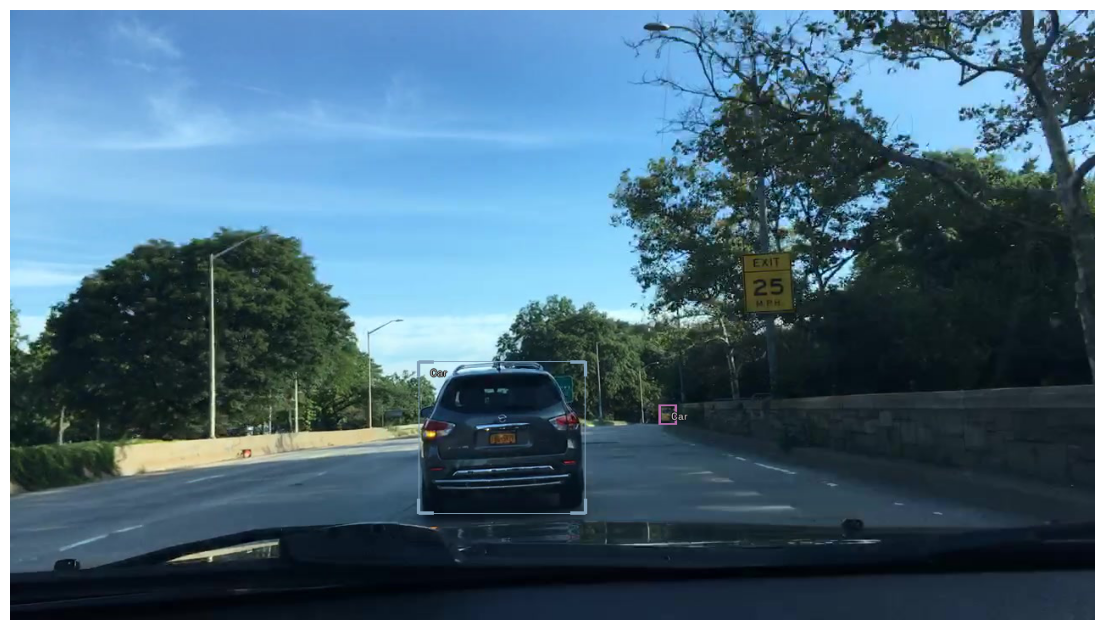

In [11]:
show_record(train_images[1], display_label=True, figsize=(14, 10))

In [12]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [13]:
train_ds = Dataset(train_images, train_tfms)
valid_ds = Dataset(valid_images, valid_tfms)

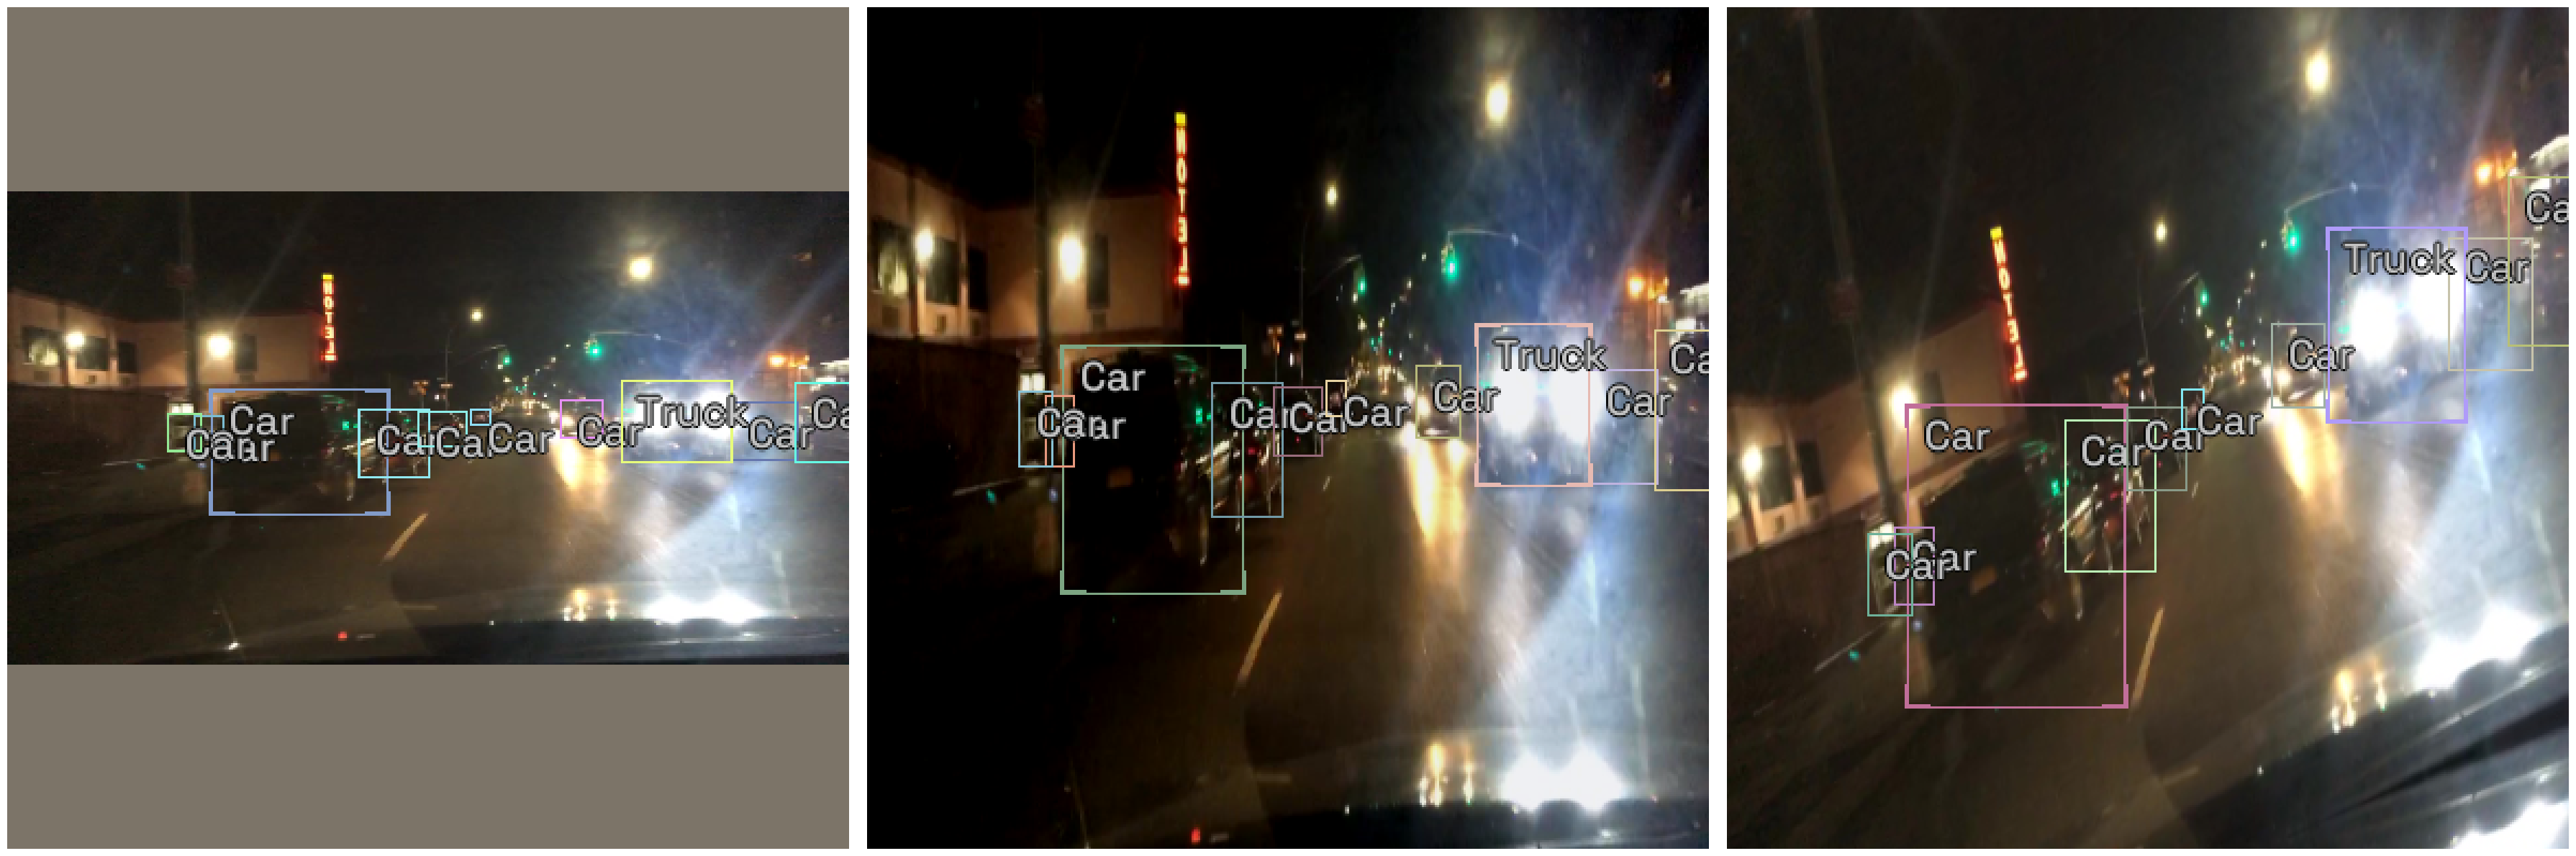

In [14]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [15]:
# Just change the value of selection to try another model

selection = 3


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.large
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ultralytics.yolov5' from '/opt/conda/lib/python3.7/site-packages/icevision/models/ultralytics/yolov5/__init__.py'>,
 {'img_size': 384})

In [16]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

In [17]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

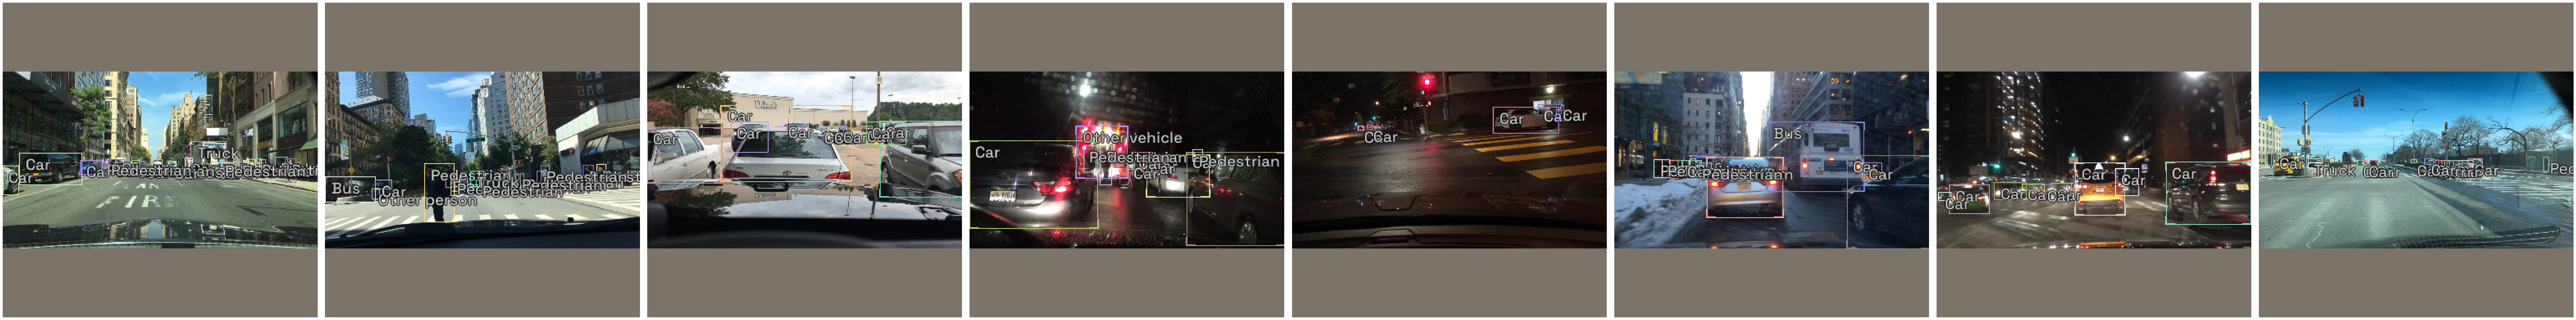

In [18]:
# show batch
model_type.show_batch(first(valid_dl), ncols=8)

In [19]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [20]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.0012022644514217973)

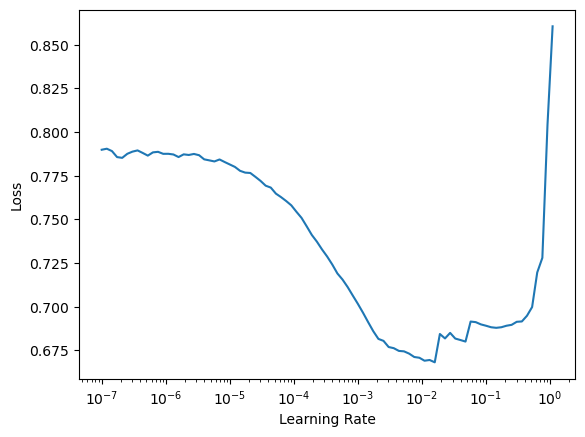

In [21]:
learn.lr_find()


In [ ]:
learn.fine_tune(10, 1e-3, freeze_epochs=2)

In [27]:
torch.save(model.state_dict(), 'model.pth')

In [30]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/1001 [00:00<?, ?it/s]

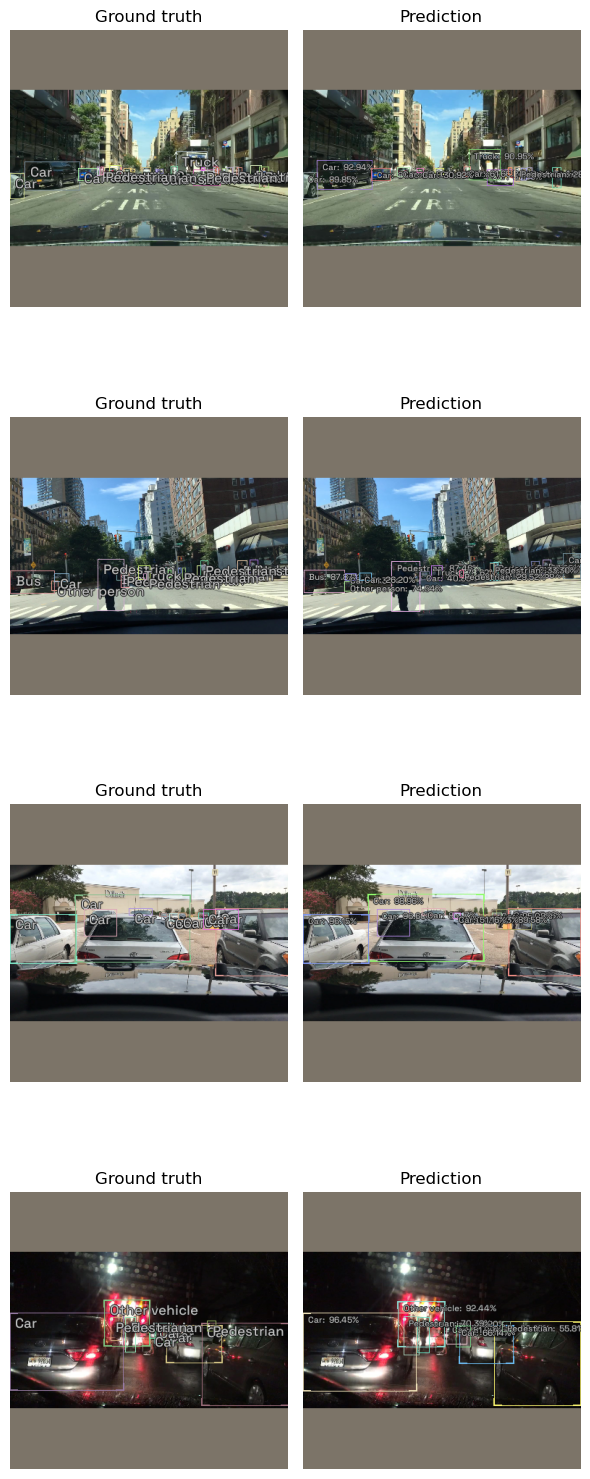

In [33]:
show_preds(preds = preds[:4])

Reference links
Code reference : https://airctic.com/0.7.0/getting_started_object_detection/
Inference reference : https://github.com/airctic/icevision/issues/551

model.pth : https://drive.google.com/file/d/1DSTseTZOfExOMQvg1e-e7fc7oCcaYE14/view?usp=sharing